In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import wandb
from easydict import EasyDict
from cvmt.ml.trainer import create_dataloader, SingletaskTraining, mean_radial_error, max_indices_4d_tensor
from cvmt.utils import (load_yaml_params, nested_dict_to_easydict)

from cvmt.ml.models import load_model

import torch
from typing import *
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D

/home/samehr/miniconda3/envs/cephal/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.chdir("../../")

In [4]:
!source configs/.env

In [5]:
CONFIG_PARAMS_PATH = "configs/params.yaml"

In [6]:
params: EasyDict = nested_dict_to_easydict(
    load_yaml_params(CONFIG_PARAMS_PATH)
)

In [7]:

if params.VERIFY.WANDB_CHECKPOINT_REFERENCE_NAME:
    try:
        # load the best model
        api = wandb.Api()

        # create the checkpoint path
        checkpoint_reference = params.VERIFY.WANDB_CHECKPOINT_REFERENCE_NAME
        artifact = api.artifact(checkpoint_reference)
        artifact_dir = artifact.download()
        checkpoint_path = artifact_dir+"/model.ckpt"
        model_id = artifact_dir.split('/')[-1]
    except Exception as e:
        print(e)
else:
    raise ValueError(
        "You have to define `VERIFY.WANDB_CHECKPOINT_REFERENCE_NAME` in the config/params.yaml"
)

print(checkpoint_path)

wandb: Downloading large artifact model-urt7dgbp:v47, 100.36MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:6.3


./artifacts/model-urt7dgbp:v47/model.ckpt


## Create data loaders

In [8]:
use_pretrain = True

task_config = params.TRAIN.V_LANDMARK_TASK
task_id = task_config.TASK_ID
batch_size = task_config.BATCH_SIZE

loss_name = params.TRAIN.LOSS_NAME
optim_params = params.TRAIN.OPTIMIZER
model_params = params.MODEL.PARAMS

n_images_to_plot = params.VERIFY.N_IMGAES_TO_PLOT

In [9]:
# val dataloader
train_dataloader = create_dataloader(
    task_id=task_id,
    batch_size=1,
    split='train',
    shuffle=False,
    params=params,
    sampler_n_samples=None,
)
# val dataloader
val_dataloader = create_dataloader(
    task_id=task_id,
    batch_size=1,
    split='val',
    shuffle=False,
    params=params,
    sampler_n_samples=None,
)

## Load the model
### use a pytorch lighning module for model class mother

See the issue below for why a pytorch lightning model cannot be loaded from checkpoint with hparams saved
and how to use pytorch lighning module to enable using a model that is defined outside a pl module.

https://github.com/Lightning-AI/lightning/issues/3629#issue-707536217

In [10]:
model = load_model(**model_params)

pl_module = SingletaskTraining(
    model=model,
    task_id=task_id,
    checkpoint_path=checkpoint_path,
    loss_name=loss_name,
)

if use_pretrain:
    model = pl_module.load_from_checkpoint(checkpoint_path,).model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
model.eval()
# model.double()

val_radial_errors = []

for i, batch in enumerate(val_dataloader):
    images, targets = batch['image'], batch['v_landmarks']
    images = images.to(device)
    targets = targets.to(device)
    # Pass images through the model
    with torch.no_grad():
        predictions = model(images, task_id=task_id)
        
    mre = mean_radial_error(preds=predictions, targets=targets)
    mre = mre.item()
    val_radial_errors.append(mre)
    

/home/samehr/miniconda3/envs/cephal/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [11]:
med_mre, perc_25_mre, perc_75_mre = np.median(val_radial_errors), np.percentile(val_radial_errors, 25), np.percentile(val_radial_errors, 75)

print(perc_25_mre, med_mre, perc_75_mre)

1.0181067883968353 1.1807273030281067 1.4310352206230164


In [12]:
mean_mre, std_mre = np.mean(val_radial_errors), np.std(val_radial_errors)

print(mean_mre, std_mre)

1.255066912530399 0.42658937756691045


In [13]:
counter_perf = 1
counter_med = 1
counter_bad = 1

perf_samples = []
med_samples = []
bad_samples = []

for i, batch in enumerate(val_dataloader):
    images, targets = batch['image'], batch['v_landmarks']
    images = images.to(device)
    targets = targets.to(device)
    # Pass images through the model
    with torch.no_grad():
        predictions = model(images, task_id=task_id)
        
    mre = mean_radial_error(preds=predictions, targets=targets)
    mre = mre.item()
    val_radial_errors.append(mre)
    
    preds_coords = max_indices_4d_tensor(predictions)
    preds_coords = preds_coords.cpu().numpy()
    preds_coords = np.squeeze(preds_coords)
    
    targs_coords = max_indices_4d_tensor(targets)
    targs_coords = targs_coords.cpu().numpy()
    targs_coords = np.squeeze(targs_coords)
    
    landmarks_coords = {'preds': preds_coords, 'targets': targs_coords}
    image = images[0].cpu().numpy()
    
    if mre >= perc_75_mre and counter_bad <= n_images_to_plot:
        # store the sample
        print(f"bad - counter: {counter_bad} , mre: {mre}")
        bad_samples.append([image, landmarks_coords, mre,])
        counter_bad += 1

    if mre <= perc_75_mre and mre >= perc_25_mre and counter_med <= n_images_to_plot:
        # store the sample
        print(f"med - counter: {counter_med} , mre: {mre}")
        med_samples.append([image, landmarks_coords, mre,])
        counter_med += 1

    if mre < perc_25_mre and counter_perf <=n_images_to_plot:
        # store the sample
        print(f"perf - counter: {counter_perf} , mre: {mre}")
        perf_samples.append([image, landmarks_coords, mre,])
        counter_perf += 1

med - counter: 1 , mre: 1.0955877304077148
bad - counter: 1 , mre: 1.6532232761383057
med - counter: 2 , mre: 1.044345498085022
perf - counter: 1 , mre: 1.0179497003555298
med - counter: 3 , mre: 1.2457057237625122
perf - counter: 2 , mre: 1.0049612522125244
med - counter: 4 , mre: 1.4309087991714478
bad - counter: 2 , mre: 1.7916359901428223
med - counter: 5 , mre: 1.0373293161392212
perf - counter: 3 , mre: 0.9868021607398987
perf - counter: 4 , mre: 1.0054668188095093
med - counter: 6 , mre: 1.1324115991592407
bad - counter: 3 , mre: 1.4998825788497925
bad - counter: 4 , mre: 3.1390881538391113
bad - counter: 5 , mre: 1.6965539455413818
perf - counter: 5 , mre: 0.8648186326026917
perf - counter: 6 , mre: 0.7878955006599426
bad - counter: 6 , mre: 1.463276982307434


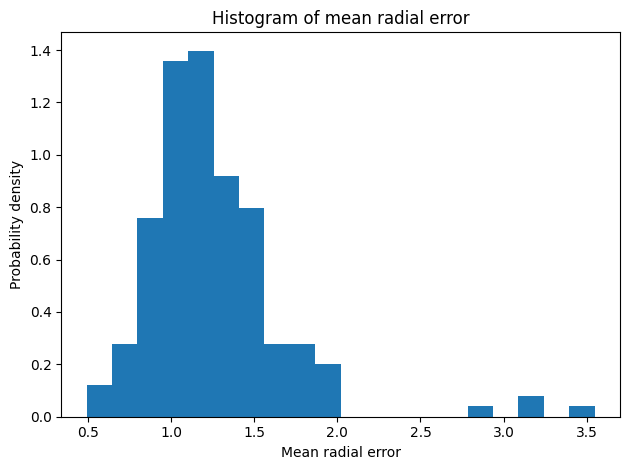

In [14]:
num_bins = 20
fig, ax = plt.subplots()
# the histogram of the data
n, bins, _ = ax.hist(val_radial_errors, num_bins, density=True)

ax.set_xlabel('Mean radial error')
ax.set_ylabel('Probability density')
ax.set_title('Histogram of mean radial error')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

fig.savefig(os.path.join("artifacts/verification", f"mean_radial_error_hist_{model_id}.jpg"), dpi=300)

## Visualize data

In [15]:
def plot_images_and_landmark_coords(
    items: List[Any],
    model_id: str,
    split: str,
    category: str='all', 
    save_fig: bool=False, 
    fig_name: str="my_figure",
):
    
    # if user desires a specific category
    if category == 'all':
        categories = ['preds', 'targets']
    else:
        categories = [category]

    # Calculate the number of rows for subplots
    if len(items)> 1:
        rows = len(items) // 2
        fig, axs = plt.subplots(rows, 2, figsize=(16, 8*rows))
        axs = axs.flatten()
    else:
        fig, axs = plt.subplots(1, 1, figsize=(16,16))
        axs = [axs]

    for ax, item in zip(axs, items):
        image, landmarks, mre = item
        image = image.squeeze()
        target_landmarks = landmarks['targets']
        pred_landmarks = landmarks['preds']
        ax.imshow(image, cmap='gray',)
        if 'targets' in categories:
            for landmark in target_landmarks:
                # Assuming each landmark is a tuple of (x, y) coordinates
                ax.add_patch(patches.Circle((landmark[1], landmark[0]), radius=1, color='yellow'))

        if 'preds' in categories:
            for i, landmark in enumerate(pred_landmarks):
                # Assuming each landmark is a tuple of (x, y) coordinates
                ax.add_patch(patches.Circle((landmark[1], landmark[0]), radius=1, color='cyan'))
                ax.text(landmark[1], landmark[0], str(i), color='orange')  # Annotate the index

        ax.set_title(f'MRE={mre}')  # Set your title here

    # Create a legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Target Landmarks',
                              markerfacecolor='yellow', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Predicted Landmarks',
                              markerfacecolor='cyan', markersize=10)]
    
    # Place the legend on the axes
    for ax in axs:
        ax.legend(handles=legend_elements, loc='lower right')
        
    plt.tight_layout()
    plt.suptitle(f"Model: {model_id}")
    plt.show()
    
    # save fig
    verify_dir = "artifacts/verification"
    os.makedirs(verify_dir, exist_ok=True) 
    if save_fig:
        fig.savefig(os.path.join(verify_dir, f"{fig_name}_{split}_{model_id}.jpg"), dpi=300)

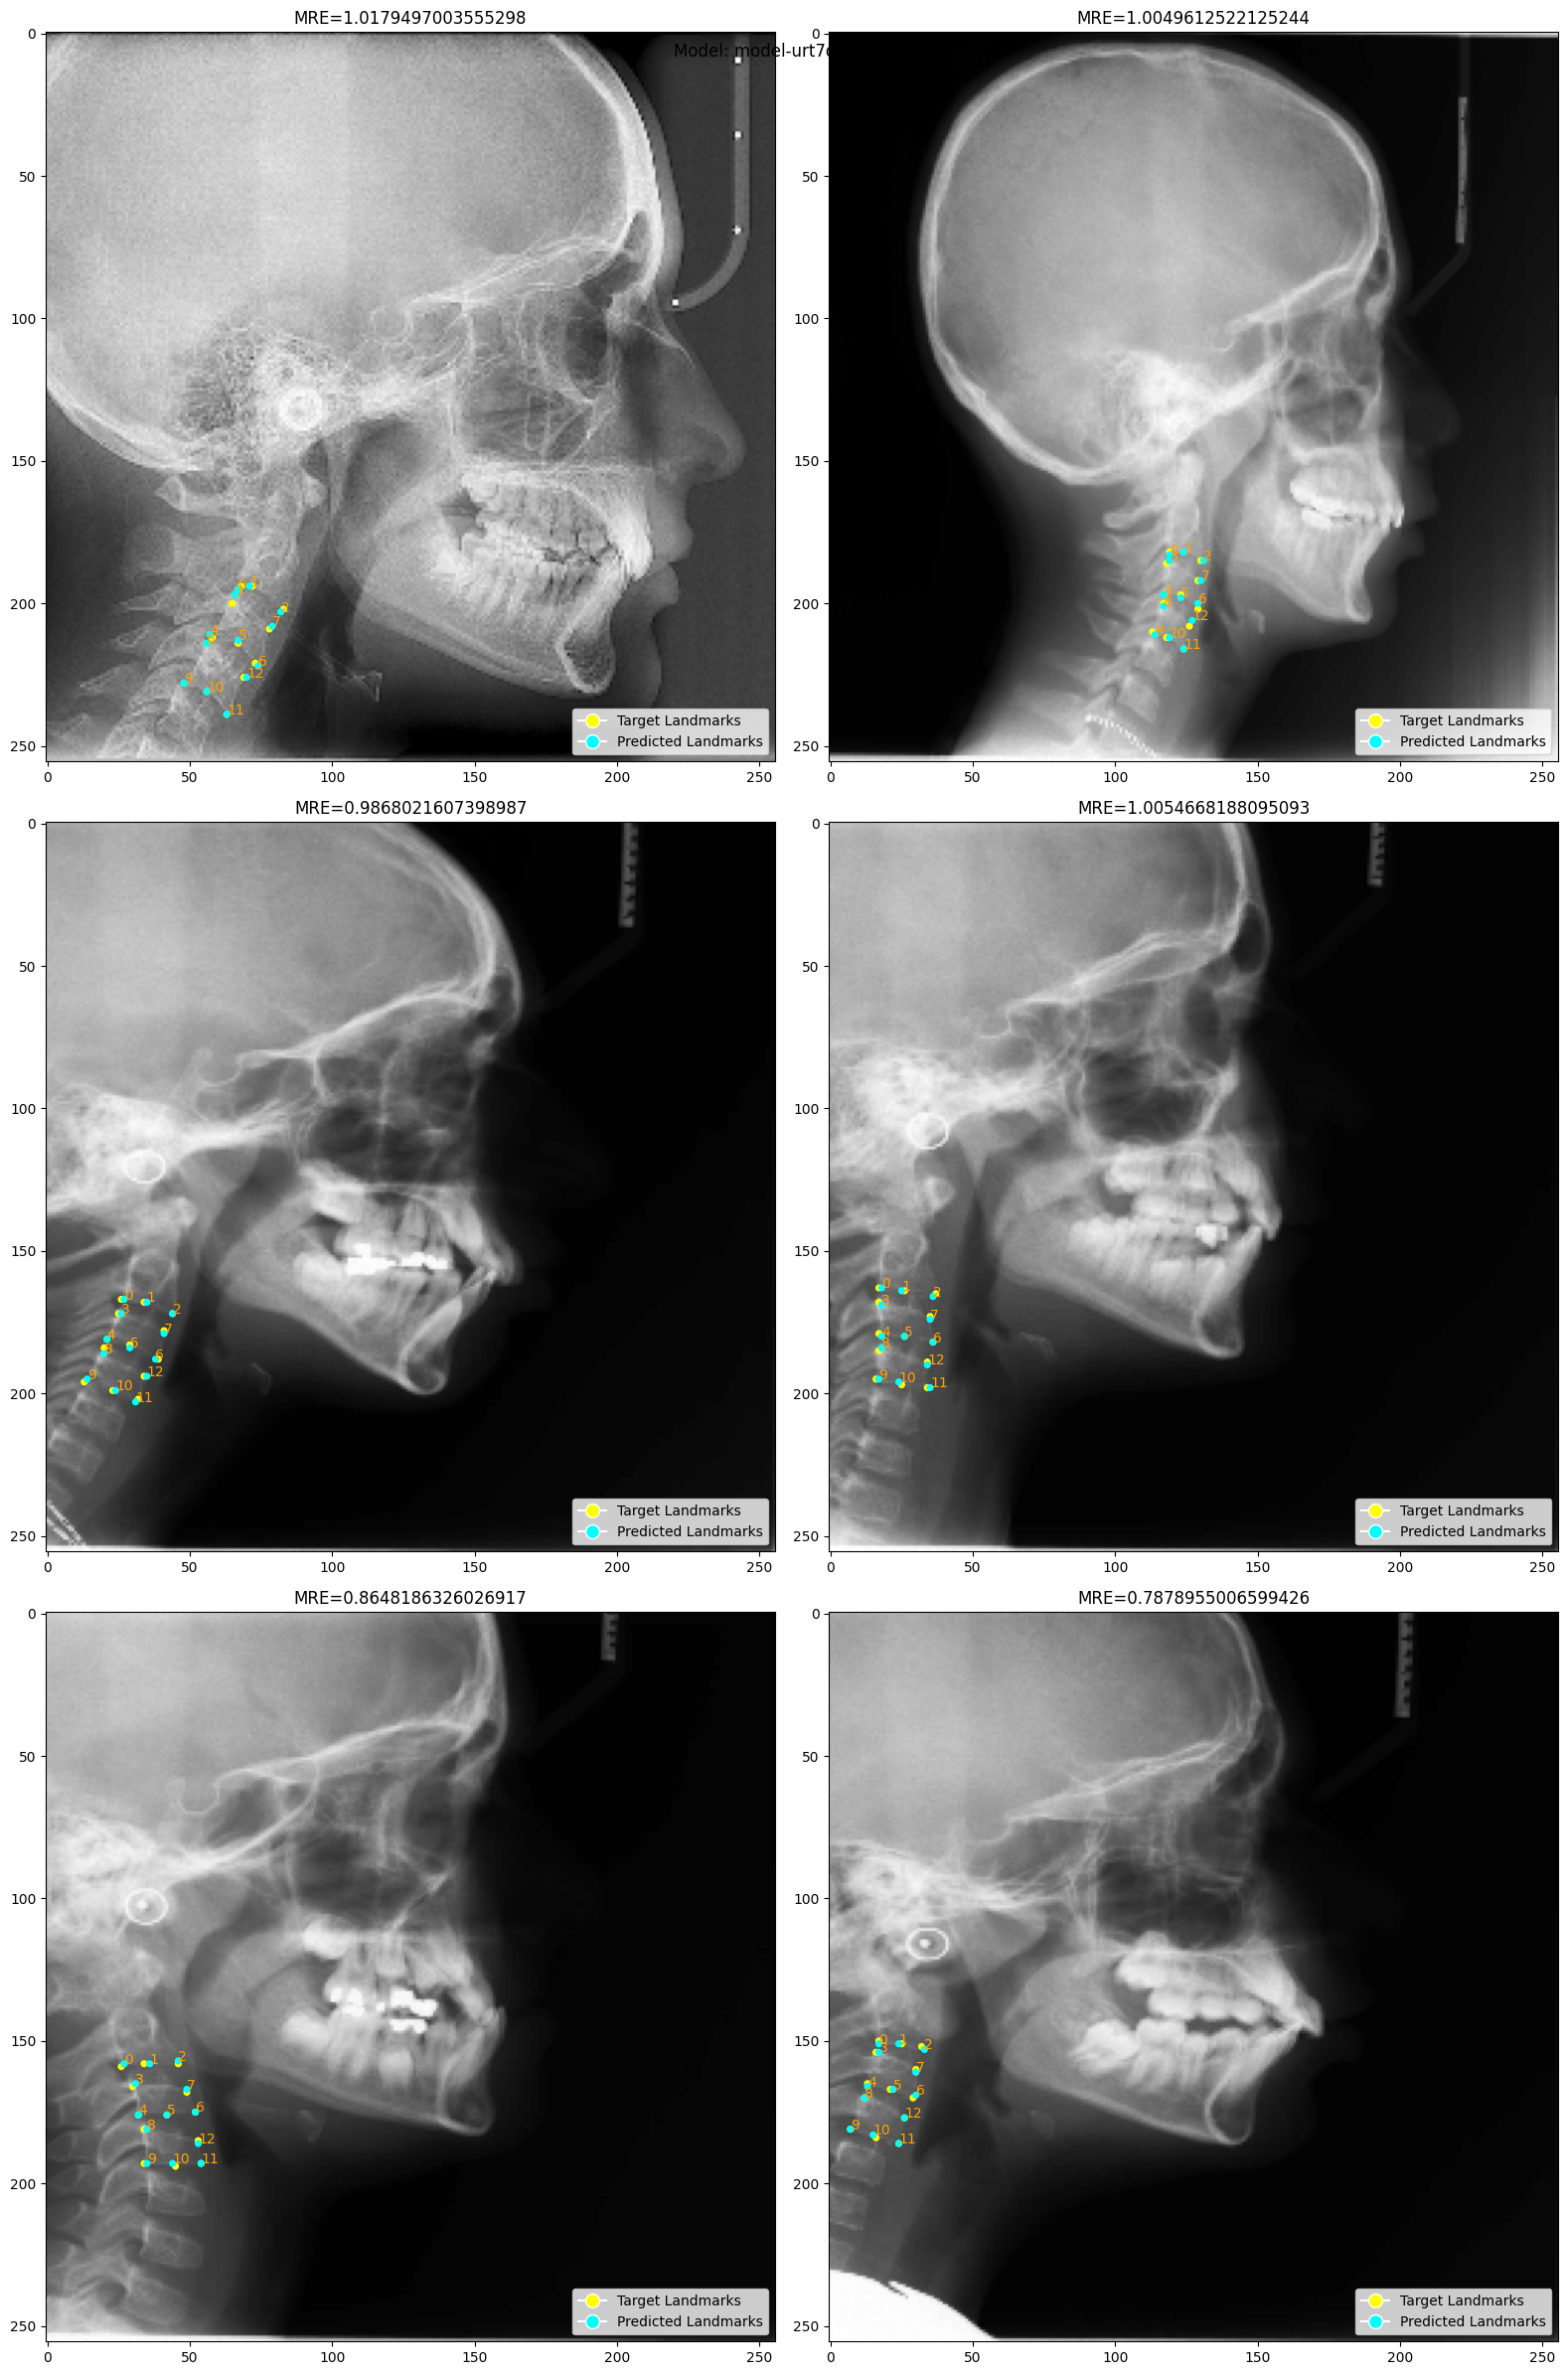

In [16]:
plot_images_and_landmark_coords(
    perf_samples,
    model_id=model_id,
    split='validation_set',
    category='all', 
    save_fig=True, 
    fig_name="perfect_perf_samples",
)

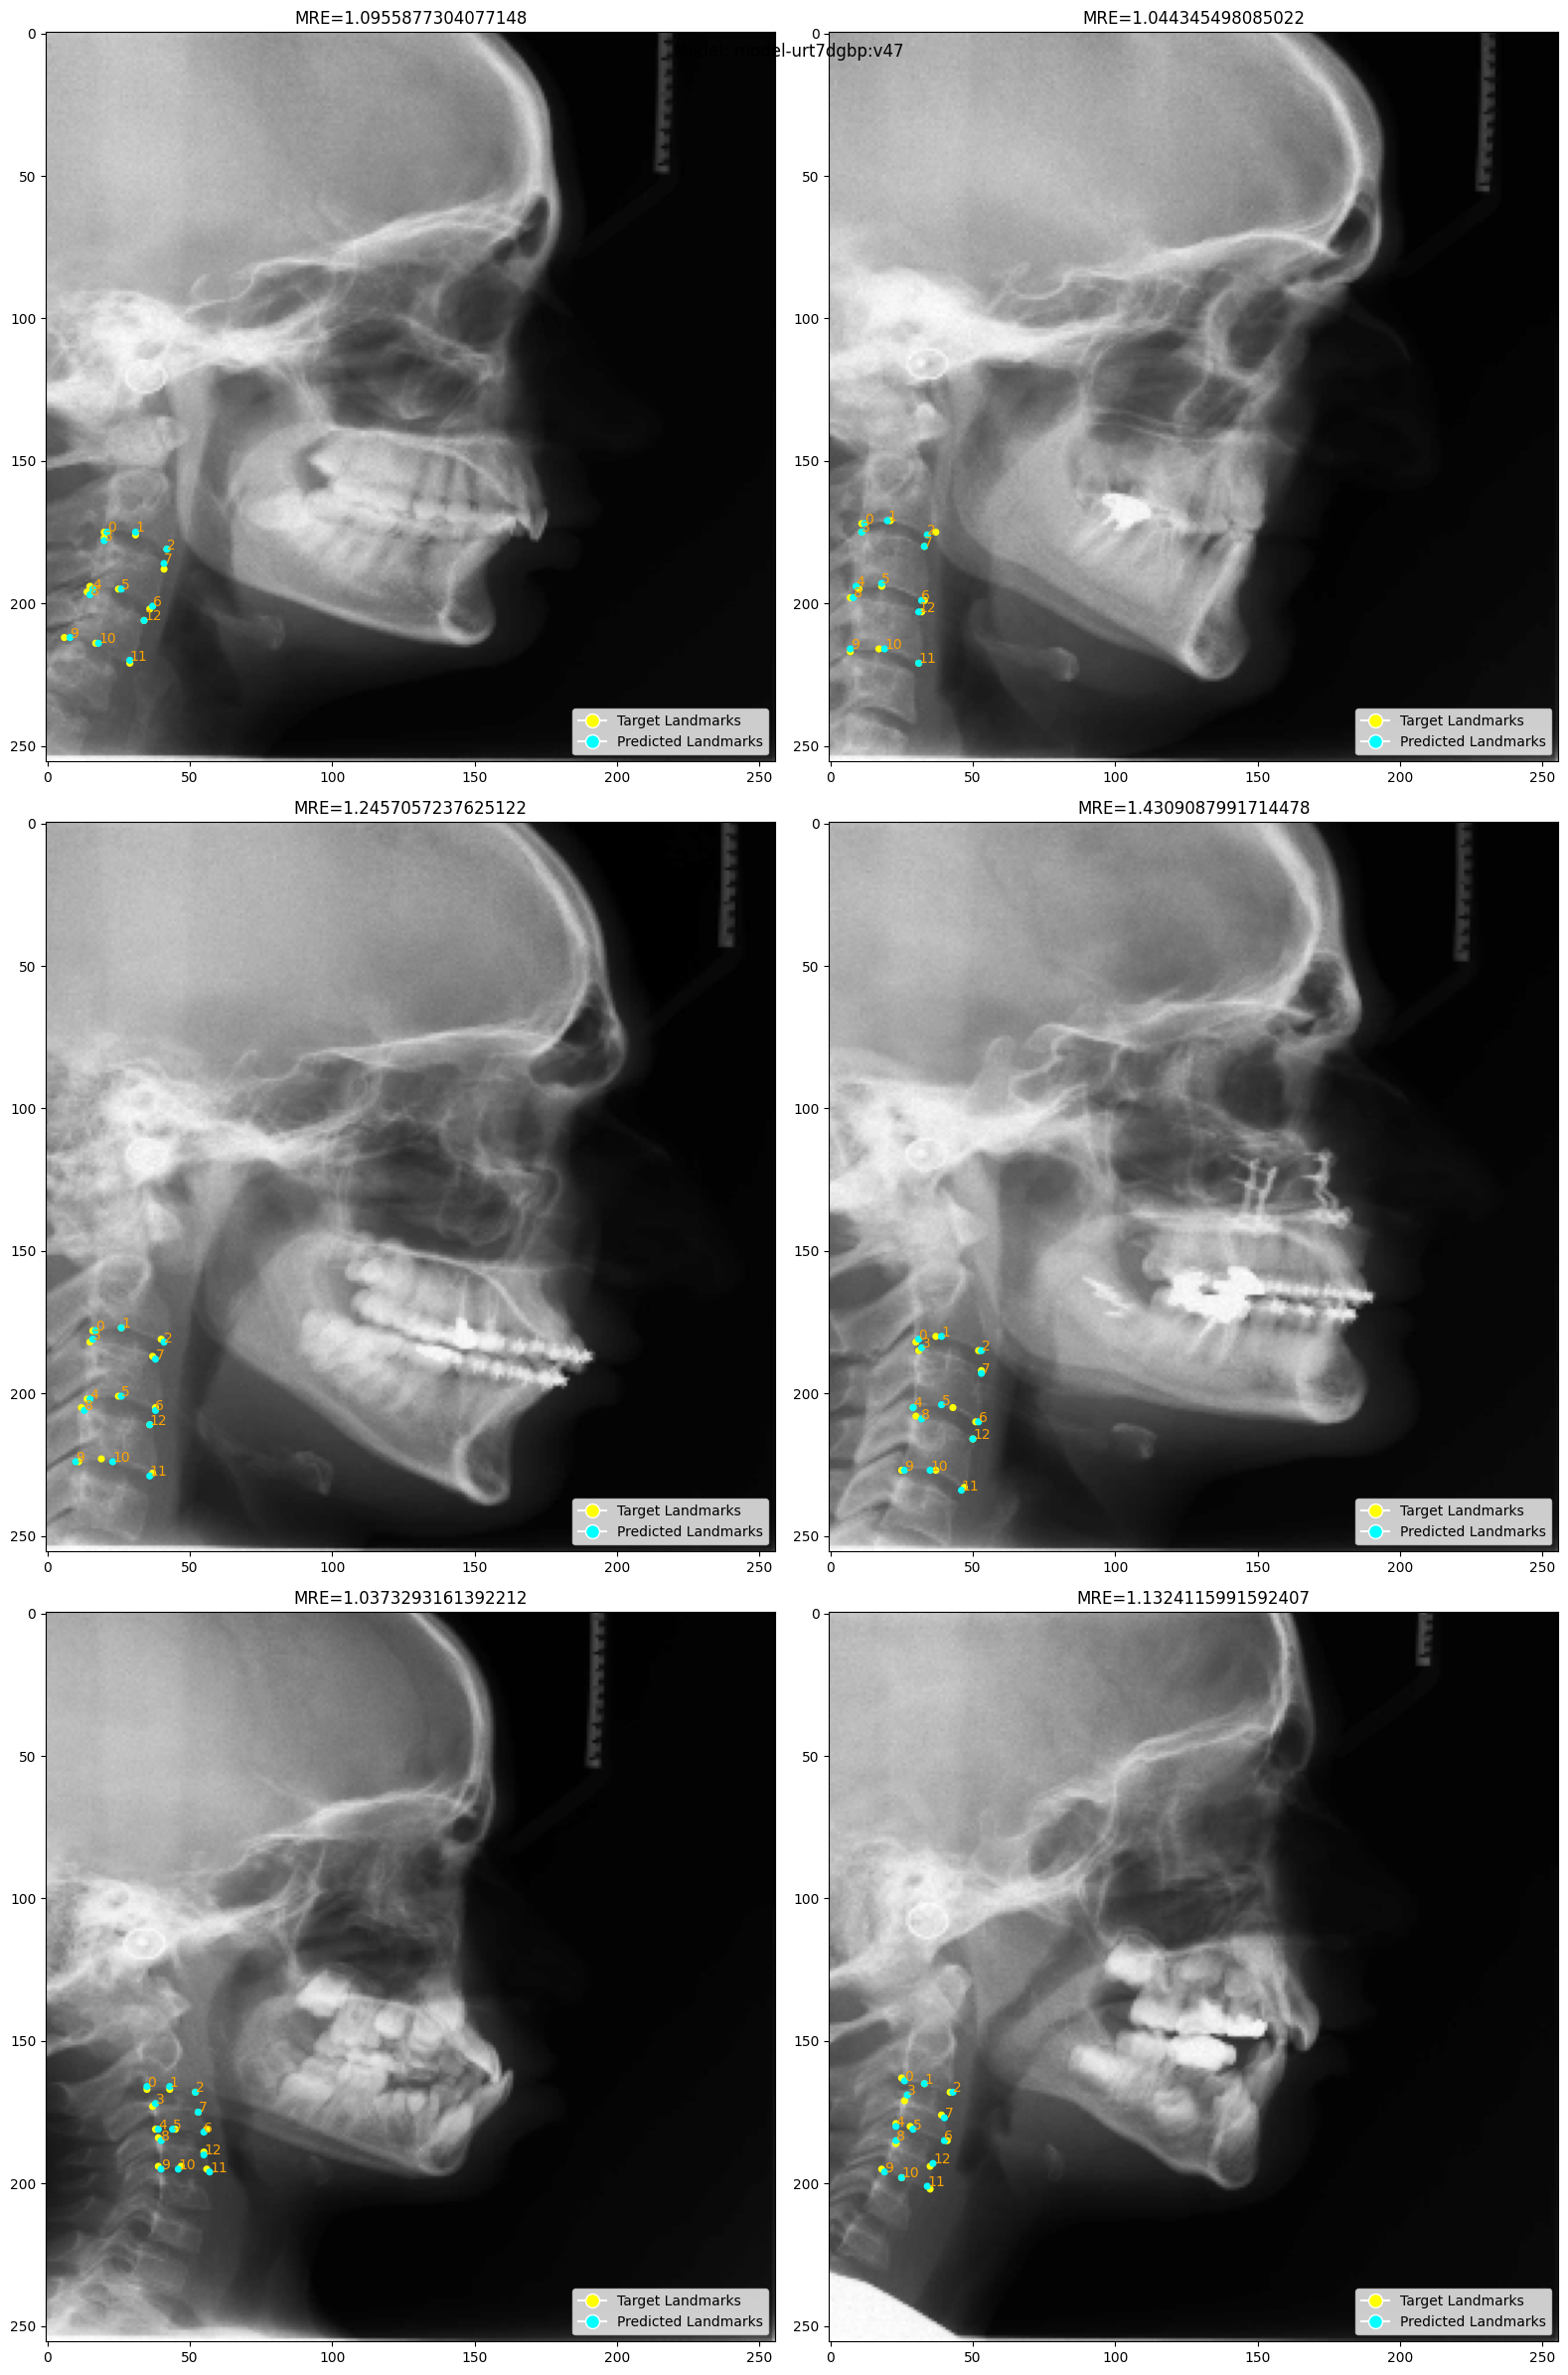

In [17]:
plot_images_and_landmark_coords(
    med_samples,
    model_id=model_id,
    split='validation_set',
    category='all', 
    save_fig=True, 
    fig_name="medium_perf_samples",
)

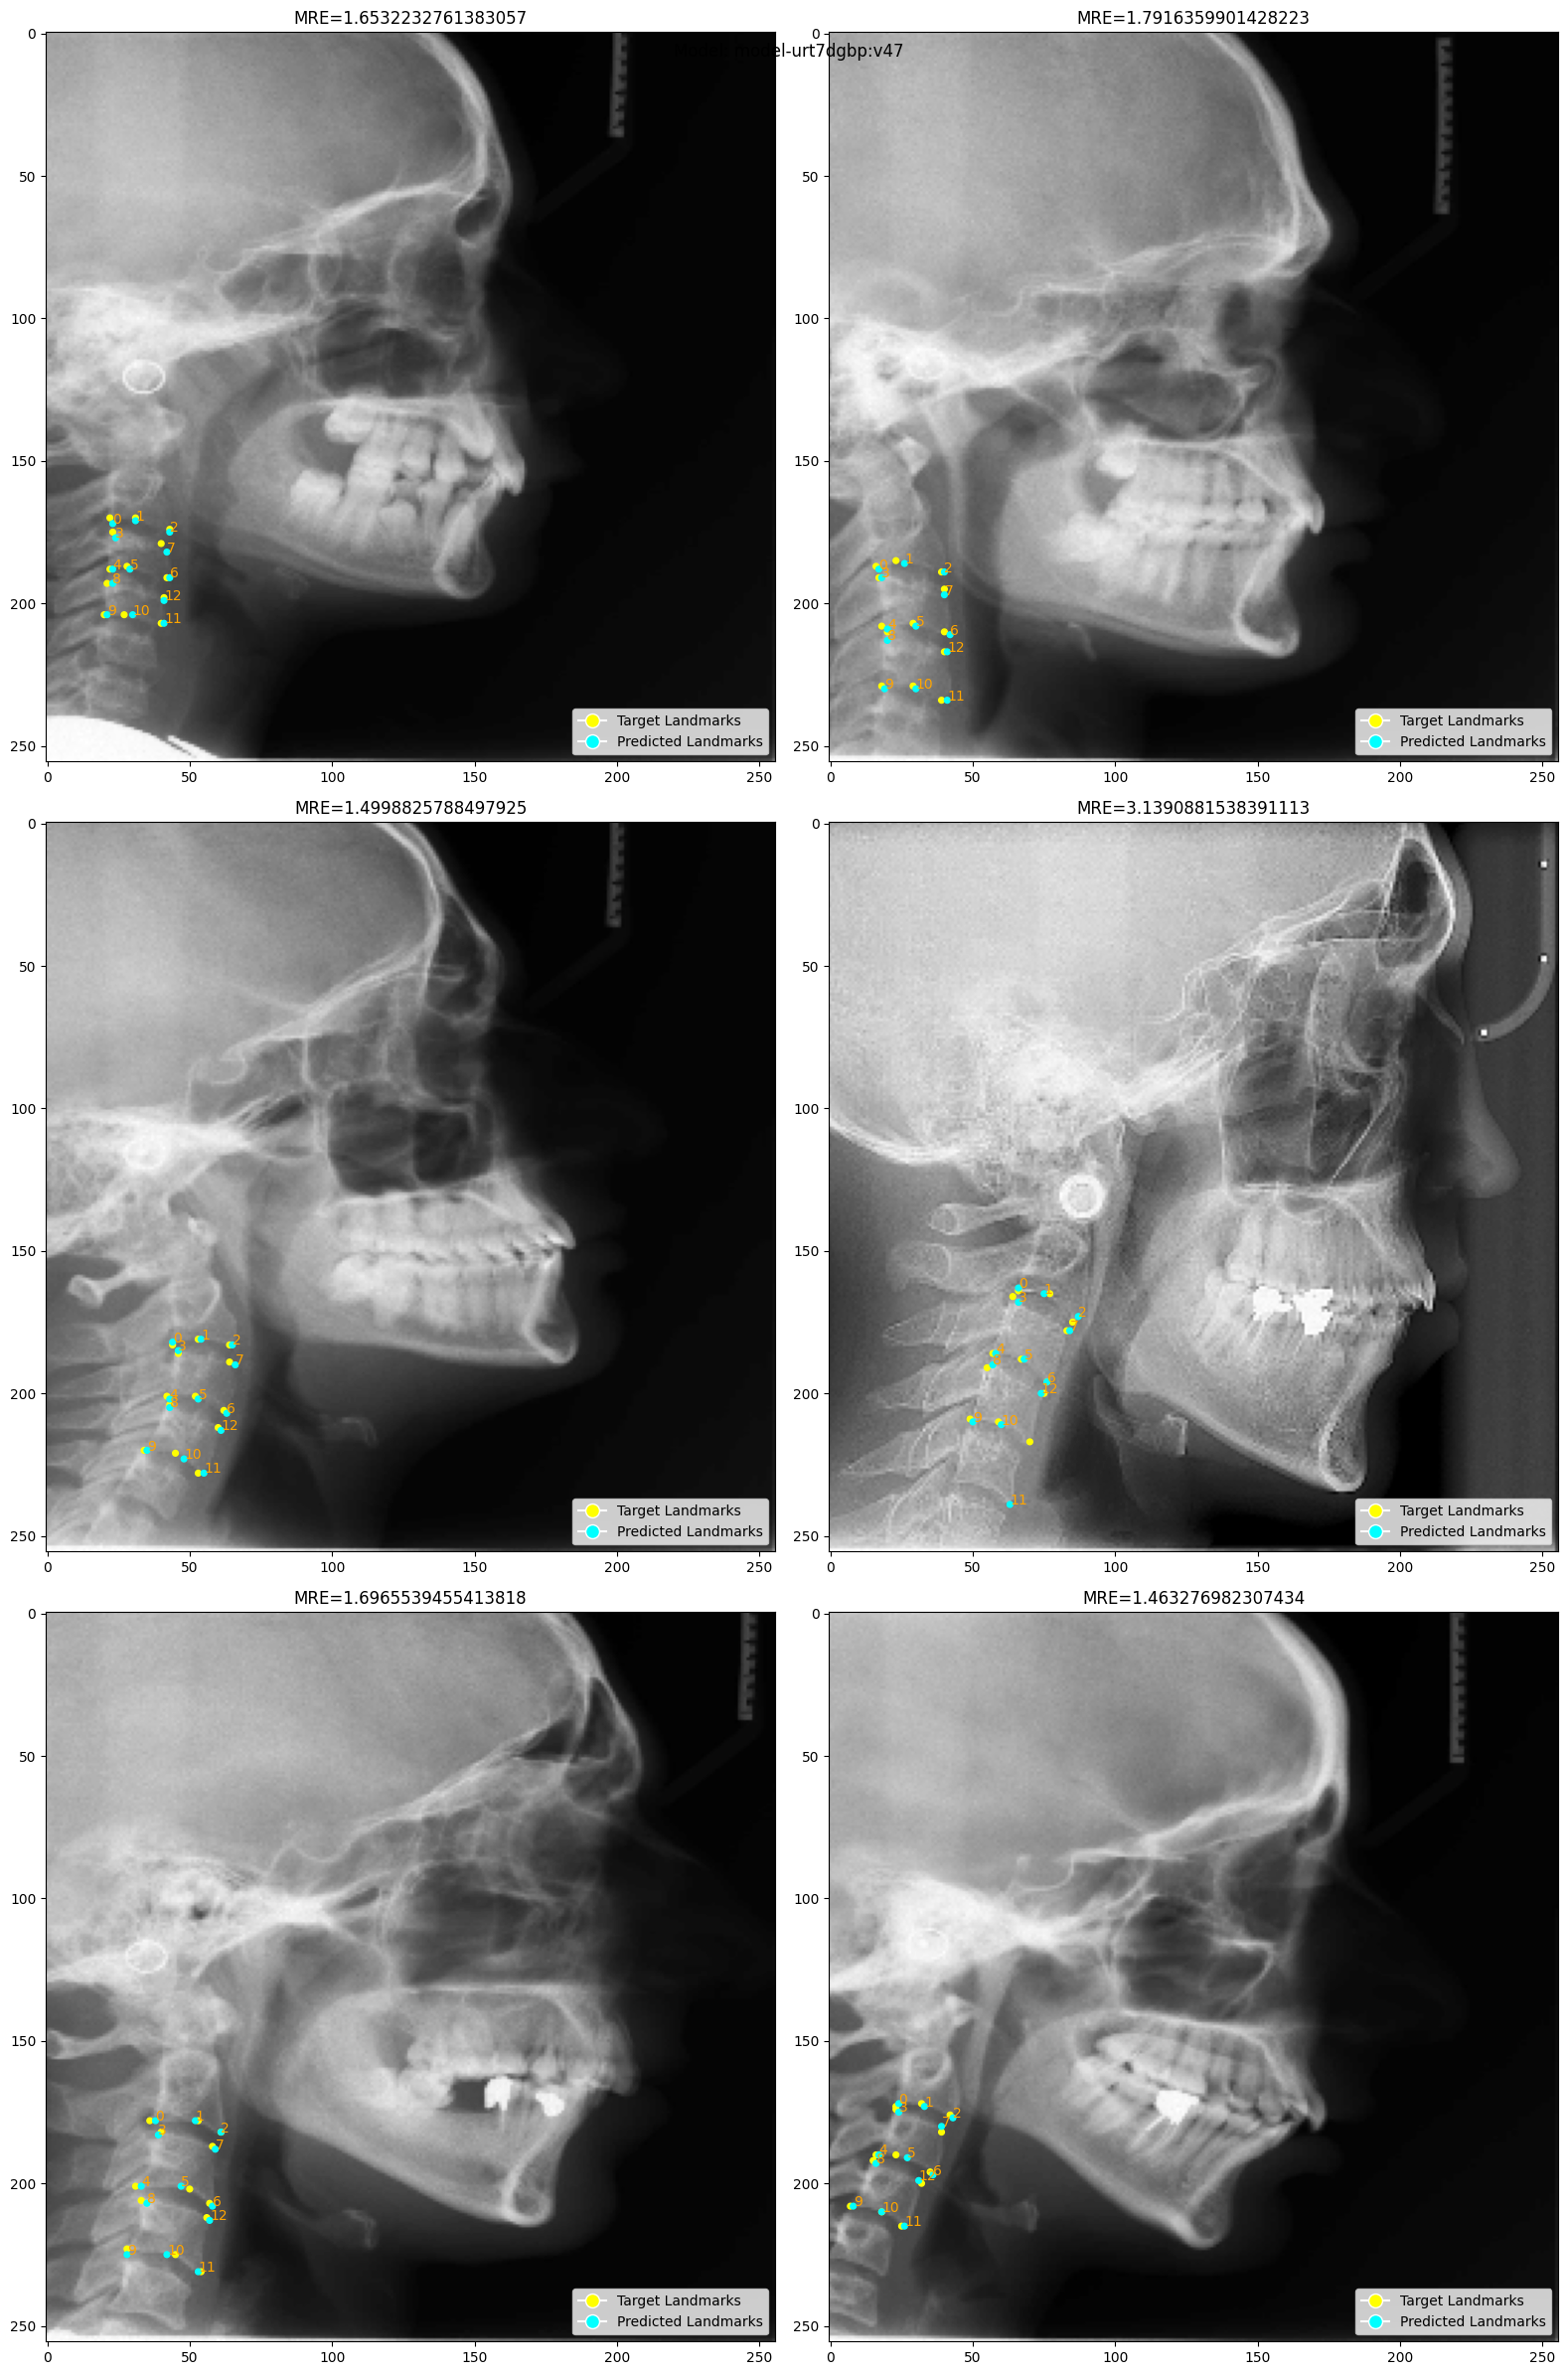

In [18]:
plot_images_and_landmark_coords(
    bad_samples,
    model_id=model_id,
    split='validation_set',
    category='all', 
    save_fig=True,
    fig_name="low_perf_samples",
)

***